In [1]:
%matplotlib inline

In [2]:
import emcee
import os
import numpy as np
from scipy.optimize import minimize
from getdist import plots, MCSamples
import pickle as pl
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import sys
sys.path.append('../')

In [3]:
from quest import Reconstruction

In [4]:
myrec = Reconstruction.from_ini('LB_FG0.ini')

DATABASE: loaded
SIMUALATION object with out FG: Loaded
FILTERING object with out FG: Loaded
QUEST object with out FG: Loaded


In [5]:
class Likelihood_CAMB:

    def __init__(self,rec_lib):
        self.rec = rec_lib
        self.lmax = len(self.rec.cl_pp) - 1
        self.pars = camb.CAMBparams()
        self.pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        self.pars.set_for_lmax(self.lmax, lens_potential_accuracy=0)

    def theory_PP(self,theta):
        omch2,alens = theta
        self.pars.set_cosmology(H0=67.5,omch2=omch2,Alens=alens)
        results = camb.get_results(self.pars)
        return results.get_lens_potential_cls(lmax=1024)[:,0]
    
    def theory_PP_binned(self,theta):
        return self.rec.bin_cell(self.theory_PP(theta))
    
    def data(self):
        return self.rec.get_qcl_wR_stat(n=400,ret='cl',n1=True,rdn0=True)
    
    def data_mean_spectra(self):
        return self.data().mean(axis=0)

    def data_covariance(self):
        return np.cov(self.data().T)

    def chisq(self,theta):
        theory = self.theory_PP_binned(theta)
        data = self.data_mean_spectra()
        cov = self.data_covariance()
        vect = theory - data
        return np.dot(vect, np.dot(np.linalg.inv(cov), vect.T))
    
    def lnlike(self,theta):
        return -0.5 * self.chisq(theta) # type: ignore   
     
    def lnprior(self,theta):
        omch2,alens = theta
        if 0.08 < omch2 < 0.15 and 0.5 < alens < 1.5:
            return 0.0
        return -np.inf
    
    def lnprob(self,theta):
        lp = self.lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.lnlike(theta)

    def MLE(self):
        np.random.seed(42)
        nll = lambda *args: -self.lnlike(*args)
        initial = np.array([0.12,1]) + 0.001 * np.random.randn(2)
        soln = minimize(nll, initial)
        return soln
        
    def sampler(self, nwalkers=32, nsteps=500):
        ndim = 2
        pos = [np.array([.12,1]) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnprob)
        sampler.run_mcmc(pos, nsteps,progress=True)
        samples = sampler.get_chain(discard=100, thin=15, flat=True)
        pl.dump(samples,open('samples.pkl','wb'))
        return samples


In [6]:
l = Likelihood(myrec)

In [7]:
l.sampler()

 78%|███████▊  | 392/500 [2:25:48<43:40, 24.26s/it]  

In [16]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)


class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_lens
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2650
 max_l_tensor = 600
 max_eta_k = 18000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.022
 omch2 = 0.122
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.5
 TCMB = 2.7255
 YHe = 0.24524332588411976
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.965
   nrun 

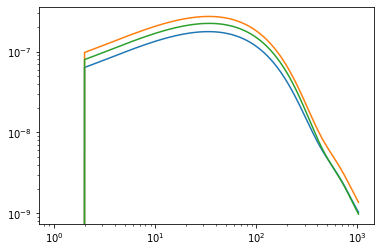

In [17]:
for v in [(0.2,1),(0.22,1.5),(0.24,1.2)]:
    pars.set_cosmology(H0=67.5,ombh2=v[0],Alens=v[1])
    results = camb.get_results(pars)
    plt.loglog(results.get_lens_potential_cls(lmax=1024)[:,0])


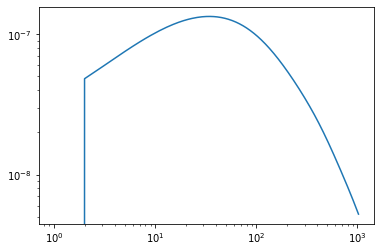

In [11]:
class Likelihood:

    def __init__(self, lib_dir,rec_lib):
        self.rec = rec_lib

    
    def theory_PP(self,alen):
        return self.rec.cl_pp * alen * self.rec.Lfac
    
    def theory_PP_binned(self,alen):
        return self.rec.bin_cell(self.theory_PP(alen))
    
    def data(self):
        return self.rec.get_qcl_wR_stat(n=400,ret='cl',n1=True,rdn0=True)
    
    def data_mean_spectra(self):
        return self.data().mean(axis=0)

    def data_covariance(self):
        return np.cov(self.data().T)

    def chisq(self,alen):
        theory = self.theory_PP_binned(alen)
        data = self.data_mean_spectra()
        cov = self.data_covariance()
        vect = theory - data
        return np.dot(vect, np.dot(np.linalg.inv(cov), vect.T))
    
    def lnlike(self,alen):
        return -0.5 * self.chisq(alen) # type: ignore   
     
    def lnprior(self,alen):
        if 0.5 < alen < 1.5:
            return 0.0
        return -np.inf
    
    def lnprob(self,alen):
        lp = self.lnprior(alen)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.lnlike(alen)

    def MLE(self):
        np.random.seed(42)
        nll = lambda *args: -self.lnlike(*args)
        initial = np.array([1]) + 0.1 * np.random.randn(1)
        soln = minimize(nll, initial)
        if soln.success:
            return soln.x
        else:
            raise ValueError(soln.message)